In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_025_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:39 - loss: 0.0160 - STD: 1.2256e-04 - MAE: 0.1083

 4/64 [>.............................] - ETA: 1s - loss: 0.0190 - STD: 2.5814e-04 - MAE: 0.0939  

 5/64 [=>............................] - ETA: 2s - loss: 0.0182 - STD: 3.6486e-04 - MAE: 0.0952

 6/64 [=>............................] - ETA: 2s - loss: 0.0183 - STD: 4.7642e-04 - MAE: 0.0997

 7/64 [==>...........................] - ETA: 7s - loss: 0.0182 - STD: 5.6584e-04 - MAE: 0.0996

10/64 [===>..........................] - ETA: 5s - loss: 0.0168 - STD: 7.3956e-04 - MAE: 0.0892

12/64 [====>.........................] - ETA: 4s - loss: 0.0164 - STD: 8.4149e-04 - MAE: 0.0847

13/64 [=====>........................] - ETA: 4s - loss: 0.0161 - STD: 9.0596e-04 - MAE: 0.0830

14/64 [=====>........................] - ETA: 4s - loss: 0.0158 - STD: 9.8013e-04 - MAE: 0.0825

15/64 [======>.......................] - ETA: 4s - loss: 0.0156 - STD: 0.0011 - MAE: 0.0829    

16/64 [======>.......................] - ETA: 4s - loss: 0.0155 - STD: 0.0011 - MAE: 0.0835

17/64 [======>.......................] - ETA: 3s - loss: 0.0154 - STD: 0.0012 - MAE: 0.0838

18/64 [=======>......................] - ETA: 3s - loss: 0.0152 - STD: 0.0013 - MAE: 0.0836

19/64 [=======>......................] - ETA: 3s - loss: 0.0150 - STD: 0.0014 - MAE: 0.0827

20/64 [========>.....................] - ETA: 3s - loss: 0.0149 - STD: 0.0014 - MAE: 0.0816

21/64 [========>.....................] - ETA: 3s - loss: 0.0148 - STD: 0.0015 - MAE: 0.0805

22/64 [=========>....................] - ETA: 3s - loss: 0.0147 - STD: 0.0015 - MAE: 0.0796

23/64 [=========>....................] - ETA: 3s - loss: 0.0146 - STD: 0.0016 - MAE: 0.0787

24/64 [==========>...................] - ETA: 3s - loss: 0.0145 - STD: 0.0017 - MAE: 0.0781

25/64 [==========>...................] - ETA: 3s - loss: 0.0144 - STD: 0.0018 - MAE: 0.0777

26/64 [===========>..................] - ETA: 2s - loss: 0.0143 - STD: 0.0019 - MAE: 0.0776

27/64 [===========>..................] - ETA: 2s - loss: 0.0143 - STD: 0.0020 - MAE: 0.0777

28/64 [============>.................] - ETA: 2s - loss: 0.0142 - STD: 0.0021 - MAE: 0.0778

29/64 [============>.................] - ETA: 2s - loss: 0.0141 - STD: 0.0022 - MAE: 0.0778

30/64 [=============>................] - ETA: 2s - loss: 0.0141 - STD: 0.0024 - MAE: 0.0776

31/64 [=============>................] - ETA: 2s - loss: 0.0140 - STD: 0.0025 - MAE: 0.0772

32/64 [==============>...............] - ETA: 2s - loss: 0.0140 - STD: 0.0026 - MAE: 0.0768

33/64 [==============>...............] - ETA: 2s - loss: 0.0139 - STD: 0.0028 - MAE: 0.0763

34/64 [==============>...............] - ETA: 2s - loss: 0.0138 - STD: 0.0030 - MAE: 0.0758

35/64 [===============>..............] - ETA: 2s - loss: 0.0137 - STD: 0.0032 - MAE: 0.0754

36/64 [===============>..............] - ETA: 2s - loss: 0.0137 - STD: 0.0034 - MAE: 0.0752

37/64 [================>.............] - ETA: 1s - loss: 0.0136 - STD: 0.0036 - MAE: 0.0751

38/64 [================>.............] - ETA: 1s - loss: 0.0135 - STD: 0.0039 - MAE: 0.0750

39/64 [=================>............] - ETA: 1s - loss: 0.0135 - STD: 0.0042 - MAE: 0.0748

40/64 [=================>............] - ETA: 1s - loss: 0.0134 - STD: 0.0045 - MAE: 0.0746

41/64 [==================>...........] - ETA: 1s - loss: 0.0133 - STD: 0.0049 - MAE: 0.0743

42/64 [==================>...........] - ETA: 1s - loss: 0.0132 - STD: 0.0053 - MAE: 0.0739

43/64 [===================>..........] - ETA: 1s - loss: 0.0131 - STD: 0.0057 - MAE: 0.0735

44/64 [===================>..........] - ETA: 1s - loss: 0.0131 - STD: 0.0062 - MAE: 0.0731

45/64 [====================>.........] - ETA: 1s - loss: 0.0130 - STD: 0.0068 - MAE: 0.0728

46/64 [====================>.........] - ETA: 1s - loss: 0.0129 - STD: 0.0074 - MAE: 0.0725

47/64 [=====================>........] - ETA: 1s - loss: 0.0128 - STD: 0.0082 - MAE: 0.0722

48/64 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 0.0089 - MAE: 0.0718

49/64 [=====================>........] - ETA: 1s - loss: 0.0126 - STD: 0.0098 - MAE: 0.0715

50/64 [======================>.......] - ETA: 0s - loss: 0.0125 - STD: 0.0107 - MAE: 0.0711

51/64 [======================>.......] - ETA: 0s - loss: 0.0123 - STD: 0.0116 - MAE: 0.0706

52/64 [=======================>......] - ETA: 0s - loss: 0.0122 - STD: 0.0127 - MAE: 0.0703

53/64 [=======================>......] - ETA: 0s - loss: 0.0121 - STD: 0.0138 - MAE: 0.0699

54/64 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 0.0150 - MAE: 0.0696

55/64 [========================>.....] - ETA: 0s - loss: 0.0119 - STD: 0.0162 - MAE: 0.0693

56/64 [=========================>....] - ETA: 0s - loss: 0.0117 - STD: 0.0174 - MAE: 0.0689

57/64 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.0186 - MAE: 0.0685

58/64 [==========================>...] - ETA: 0s - loss: 0.0115 - STD: 0.0197 - MAE: 0.0682

59/64 [==========================>...] - ETA: 0s - loss: 0.0114 - STD: 0.0208 - MAE: 0.0678

60/64 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 0.0219 - MAE: 0.0674

61/64 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 0.0228 - MAE: 0.0670

62/64 [============================>.] - ETA: 0s - loss: 0.0110 - STD: 0.0237 - MAE: 0.0666

63/64 [============================>.] - ETA: 0s - loss: 0.0109 - STD: 0.0246 - MAE: 0.0662

64/64 [==============================] - ETA: 0s - loss: 0.0108 - STD: 0.0256 - MAE: 0.0658

64/64 [==============================] - 7s 82ms/step - loss: 0.0108 - STD: 0.0256 - MAE: 0.0658 - val_loss: 0.0057 - val_STD: 0.0636 - val_MAE: 0.0468


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0855 - MAE: 0.0417

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0869 - MAE: 0.0413

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0882 - MAE: 0.0410

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0895 - MAE: 0.0407

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0911 - MAE: 0.0406

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0919 - MAE: 0.0405

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0927 - MAE: 0.0404

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0934 - MAE: 0.0402

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0939 - MAE: 0.0399

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0935 - MAE: 0.0396

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0930 - MAE: 0.0394

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0928 - MAE: 0.0393

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0929 - MAE: 0.0392

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0929 - MAE: 0.0390

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0932 - MAE: 0.0389

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0936 - MAE: 0.0388

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0941 - MAE: 0.0387

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0943 - MAE: 0.0386

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0945 - MAE: 0.0385

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0947 - MAE: 0.0384

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0951 - MAE: 0.0383

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0952 - MAE: 0.0382

23/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0953 - MAE: 0.0381

24/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0953 - MAE: 0.0379

25/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0954 - MAE: 0.0379

26/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0957 - MAE: 0.0378

27/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0958 - MAE: 0.0377

28/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0958 - MAE: 0.0376

29/64 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0961 - MAE: 0.0375

30/64 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0963 - MAE: 0.0374

31/64 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0962 - MAE: 0.0373

32/64 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0963 - MAE: 0.0372

33/64 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0372

34/64 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0965 - MAE: 0.0371

35/64 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0966 - MAE: 0.0370

36/64 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0967 - MAE: 0.0370

37/64 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0969 - MAE: 0.0369

38/64 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0968 - MAE: 0.0368

39/64 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0969 - MAE: 0.0368

40/64 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0367

41/64 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0972 - MAE: 0.0366

42/64 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0972 - MAE: 0.0365

43/64 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0974 - MAE: 0.0365

44/64 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0975 - MAE: 0.0364

45/64 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0976 - MAE: 0.0364

46/64 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0977 - MAE: 0.0363

47/64 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0978 - MAE: 0.0362

48/64 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0978 - MAE: 0.0362

49/64 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0361

50/64 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0981 - MAE: 0.0361

51/64 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0981 - MAE: 0.0360

52/64 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0982 - MAE: 0.0359

53/64 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0983 - MAE: 0.0359

54/64 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0983 - MAE: 0.0358

55/64 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0983 - MAE: 0.0358

56/64 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0357

57/64 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0356

58/64 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0986 - MAE: 0.0356

59/64 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0355

61/64 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0354

62/64 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0354

63/64 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0353

64/64 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0353

64/64 [==============================] - 4s 69ms/step - loss: 0.0029 - STD: 0.0989 - MAE: 0.0353 - val_loss: 0.0028 - val_STD: 0.0865 - val_MAE: 0.0350


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.1053 - MAE: 0.0331

 2/64 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0323

 3/64 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1012 - MAE: 0.0321

 4/64 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0321

 5/64 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0321

 6/64 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0322

 8/64 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0320

 9/64 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0320

10/64 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0320

11/64 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0319

12/64 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0320

13/64 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0320

14/64 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0320

15/64 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0320

16/64 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0320

17/64 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0320

18/64 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0319

19/64 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0319

20/64 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0319

21/64 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0319

22/64 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0319

23/64 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0319

24/64 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0319

25/64 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0319

26/64 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0319

27/64 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0319

28/64 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0319

29/64 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0319

30/64 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0318

31/64 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0318

32/64 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0318

33/64 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0318

34/64 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0318

35/64 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0318

36/64 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0318

37/64 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0317

38/64 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0317

39/64 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0317

40/64 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0317

41/64 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0317

42/64 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0317

43/64 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0317

44/64 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0317

45/64 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0317

46/64 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

47/64 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0317

48/64 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

49/64 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

50/64 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

51/64 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0317

52/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

53/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

54/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0317

55/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

56/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

57/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

58/64 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

59/64 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

60/64 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

61/64 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

62/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

63/64 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0316

64/64 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0316

64/64 [==============================] - 4s 68ms/step - loss: 0.0021 - STD: 0.1028 - MAE: 0.0316 - val_loss: 0.0026 - val_STD: 0.0898 - val_MAE: 0.0338


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0310

 2/64 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1055 - MAE: 0.0310

 3/64 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1045 - MAE: 0.0311

 4/64 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0309

 5/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0310

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0309

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0309

 9/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0309

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0309

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0309

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0309

13/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0309

14/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0308

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0308

16/64 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0308

17/64 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0308

18/64 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0308

19/64 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0308

20/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0308

21/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0308

22/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

23/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

24/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

25/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0307

26/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0306

27/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0306

28/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0306

29/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0306

30/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0306

31/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0306

32/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0306

33/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0305

34/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0305

35/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0305

36/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0305

37/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0305

38/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

39/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

40/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0305

41/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

42/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0305

43/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

44/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

45/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

46/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0304

47/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0304

48/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0304

49/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0304

50/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0304

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0304

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0304

53/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0304

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0304

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0304

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0304

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0304

58/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0304

59/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0304

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0303

61/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0303

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0303

63/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0303

64/64 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0303

64/64 [==============================] - 4s 68ms/step - loss: 0.0020 - STD: 0.1037 - MAE: 0.0303 - val_loss: 0.0024 - val_STD: 0.0899 - val_MAE: 0.0326


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0303

 2/64 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0302

 3/64 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0299

 4/64 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0298

 5/64 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0298

 6/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0299

 7/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0299

 8/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0298

 9/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0299

10/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0299

11/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0299

12/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0298

13/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0299

14/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0299

15/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0299

16/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0299

17/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0299

18/64 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0299

19/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0299

20/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0299

21/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0299

22/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0299

23/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0299

24/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0299

25/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0298

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0299

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0298

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0298

29/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0298

30/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0298

31/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0298

32/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0298

33/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

34/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

35/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

36/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0297

37/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

38/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0297

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0297

40/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0297

41/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0297

42/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0297

43/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0297

44/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0297

45/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0297

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0297

47/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0297

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0297

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0297

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0297

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0297

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0297

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0297

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0297

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0297

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0297

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0297

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0297

64/64 [==============================] - 4s 69ms/step - loss: 0.0019 - STD: 0.1040 - MAE: 0.0297 - val_loss: 0.0025 - val_STD: 0.0851 - val_MAE: 0.0338


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0966 - MAE: 0.0314

 2/64 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0307

 3/64 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 4/64 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0298

 5/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0301

 6/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0301

 7/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0300

 8/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0298

 9/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0299

10/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0299

11/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0299

12/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0298

13/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0297

14/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0297

15/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0296

16/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0296

17/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0295

18/64 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0295

19/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0295

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0294

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0294

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0294

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0293

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0292

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0292

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0292

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

32/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

33/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

34/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

36/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0292

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0292

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0292

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0292

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0292

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0293

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0293

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0293

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

64/64 [==============================] - 4s 69ms/step - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292 - val_loss: 0.0023 - val_STD: 0.0879 - val_MAE: 0.0322


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.0986 - MAE: 0.0290

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0292

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0290

 4/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

 5/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0292

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0291

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0290

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0290

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0289

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0290

18/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

19/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0291

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0291

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0291

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

32/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

33/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

34/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

36/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

64/64 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290 - val_loss: 0.0023 - val_STD: 0.0870 - val_MAE: 0.0324


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0300

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0291

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0287

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0285

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0287

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

18/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

19/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0288

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0288

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0288

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

64/64 [==============================] - 4s 69ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284 - val_loss: 0.0022 - val_STD: 0.0917 - val_MAE: 0.0307


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

64/64 [==============================] - 4s 69ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279 - val_loss: 0.0021 - val_STD: 0.0926 - val_MAE: 0.0302


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0285

 4/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0293

 5/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0298

 6/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0301

 7/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0299

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0295

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0294

10/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0296

11/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0297

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0295

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294

14/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

15/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0297

16/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0296

17/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0298

18/64 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0300

19/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

20/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0302

21/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

22/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0304

23/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0307

24/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0308

25/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0307

26/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0311

27/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0311

28/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0311

29/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0312

30/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0310

31/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0310

32/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0310

33/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0310

34/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0309

35/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0309

36/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0308

37/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0308

38/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0308

39/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0307

41/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0306

42/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0306

43/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0305

44/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

45/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0304

47/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0303

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0303

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0302

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0302

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0301

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0301

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0300

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0300

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0298

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0298

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0298

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0296

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0296

64/64 [==============================] - 4s 69ms/step - loss: 0.0019 - STD: 0.1038 - MAE: 0.0296 - val_loss: 0.0021 - val_STD: 0.0933 - val_MAE: 0.0300


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0277

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0276

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0278

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274 - val_loss: 0.0022 - val_STD: 0.0951 - val_MAE: 0.0301


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0274

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1089 - MAE: 0.0274

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0274

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0274

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0274

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0274

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0272

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0271

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0271

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0271

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0271

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0272

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0271

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271 - val_loss: 0.0021 - val_STD: 0.0933 - val_MAE: 0.0298


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0263

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0270

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0272

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0274

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0275

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273 - val_loss: 0.0021 - val_STD: 0.0941 - val_MAE: 0.0297


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0268

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0268

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0272

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271 - val_loss: 0.0020 - val_STD: 0.0919 - val_MAE: 0.0297


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0272

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0268

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0279

64/64 [==============================] - 4s 69ms/step - loss: 0.0017 - STD: 0.1050 - MAE: 0.0279 - val_loss: 0.0020 - val_STD: 0.0904 - val_MAE: 0.0296


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1074 - MAE: 0.0293

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0285

 5/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0292

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0290

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0288

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0291

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0287

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0284

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0284

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0282

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271 - val_loss: 0.0020 - val_STD: 0.0925 - val_MAE: 0.0294


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0270

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0269

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0269

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0269

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268 - val_loss: 0.0020 - val_STD: 0.0948 - val_MAE: 0.0291


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0266

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0264

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0022 - val_STD: 0.0969 - val_MAE: 0.0301


Epoch 19/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0270

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0269

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0269

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0268

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

64/64 [==============================] - 4s 68ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270 - val_loss: 0.0020 - val_STD: 0.0955 - val_MAE: 0.0288


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0264

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0267

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0270

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0271

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0271

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0270

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0270

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0270

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0270

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0269

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0929 - val_MAE: 0.0289


Epoch 21/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265 - val_loss: 0.0019 - val_STD: 0.0943 - val_MAE: 0.0286


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0257

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0260

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0265

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0266

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0020 - val_STD: 0.0956 - val_MAE: 0.0291


Epoch 23/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0264

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0265

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0263

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0262

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0262

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0262

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0262

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0262

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0262

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0262

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0948 - val_MAE: 0.0285


Epoch 24/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0258

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0264

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0271

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0274

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0275

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0276

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0272

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

64/64 [==============================] - 4s 67ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264 - val_loss: 0.0020 - val_STD: 0.0964 - val_MAE: 0.0292


Epoch 25/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0263

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0264

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0022 - val_STD: 0.0970 - val_MAE: 0.0301


Epoch 26/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0266

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0262

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0265

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0265

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260 - val_loss: 0.0022 - val_STD: 0.0982 - val_MAE: 0.0301


Epoch 27/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0270

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0263

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0266

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0270

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0273

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0270

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0271

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0272

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0271

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0270

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0270

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0270

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0269

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0269

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0940 - val_MAE: 0.0282


Epoch 28/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0258

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0258

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262 - val_loss: 0.0020 - val_STD: 0.0975 - val_MAE: 0.0289


Epoch 29/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0257

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1093 - MAE: 0.0261

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0263

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0267

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0267

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0267

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0267

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0265

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0265

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0926 - val_MAE: 0.0288


Epoch 30/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0272

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1082 - MAE: 0.0271

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

64/64 [==============================] - 4s 67ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259 - val_loss: 0.0021 - val_STD: 0.0985 - val_MAE: 0.0292


Epoch 31/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0263

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0266

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0264

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0262

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0262

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0262

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258 - val_loss: 0.0018 - val_STD: 0.0936 - val_MAE: 0.0280


Epoch 32/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.0991 - MAE: 0.0260

 2/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0263

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0262

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0260

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - 4s 70ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261 - val_loss: 0.0019 - val_STD: 0.0951 - val_MAE: 0.0285


Epoch 33/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0255

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0257

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0256

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0257

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0262

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0262

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0261

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258 - val_loss: 0.0018 - val_STD: 0.0937 - val_MAE: 0.0278


Epoch 34/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0259

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0264

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0261

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257 - val_loss: 0.0020 - val_STD: 0.0973 - val_MAE: 0.0284


Epoch 35/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0250

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1080 - MAE: 0.0251

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1079 - MAE: 0.0251

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0252

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0251

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0252

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0252

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0252

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0252

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0252

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0254

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254 - val_loss: 0.0020 - val_STD: 0.0979 - val_MAE: 0.0283


Epoch 36/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0252

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0251

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0253

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - 4s 67ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0020 - val_STD: 0.0975 - val_MAE: 0.0288


Epoch 37/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0258

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0253

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0254

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0253

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254 - val_loss: 0.0019 - val_STD: 0.0976 - val_MAE: 0.0279


Epoch 38/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1088 - MAE: 0.0252

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1096 - MAE: 0.0252

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0250

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0250

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0250

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0249

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0250

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0252

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0256

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0258

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0258

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0021 - val_STD: 0.0993 - val_MAE: 0.0291


Epoch 39/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1127 - MAE: 0.0258

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0255

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1081 - MAE: 0.0256

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0255

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0253

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0252

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0253

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0252

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0253

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258 - val_loss: 0.0020 - val_STD: 0.0982 - val_MAE: 0.0287


Epoch 40/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0256

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0251

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0250

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0250

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0250

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0250

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0250

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0250

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0250

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0250

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0250

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0020 - val_STD: 0.0973 - val_MAE: 0.0289


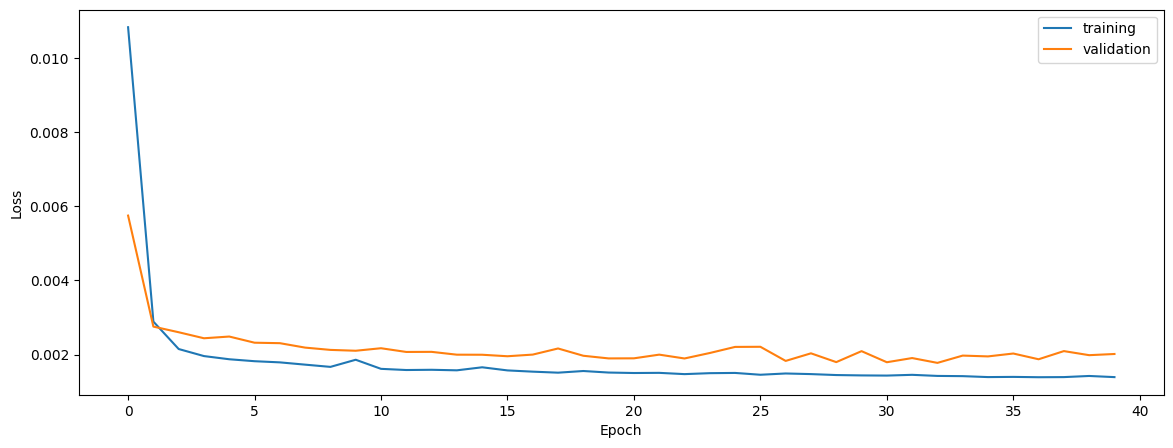

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


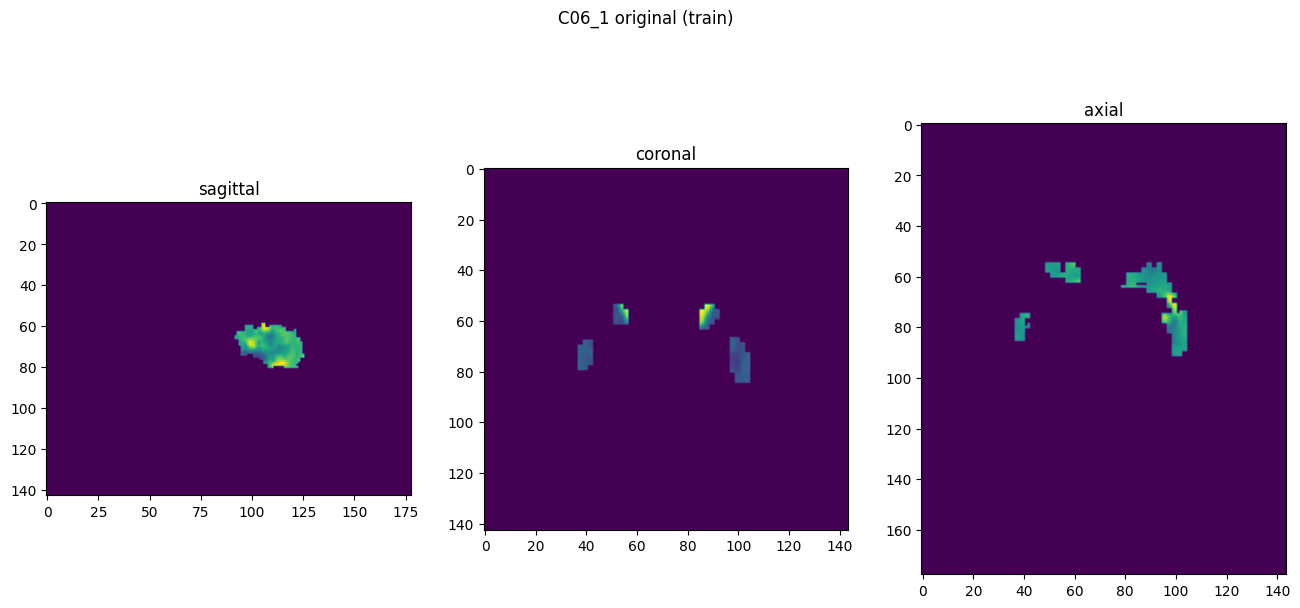

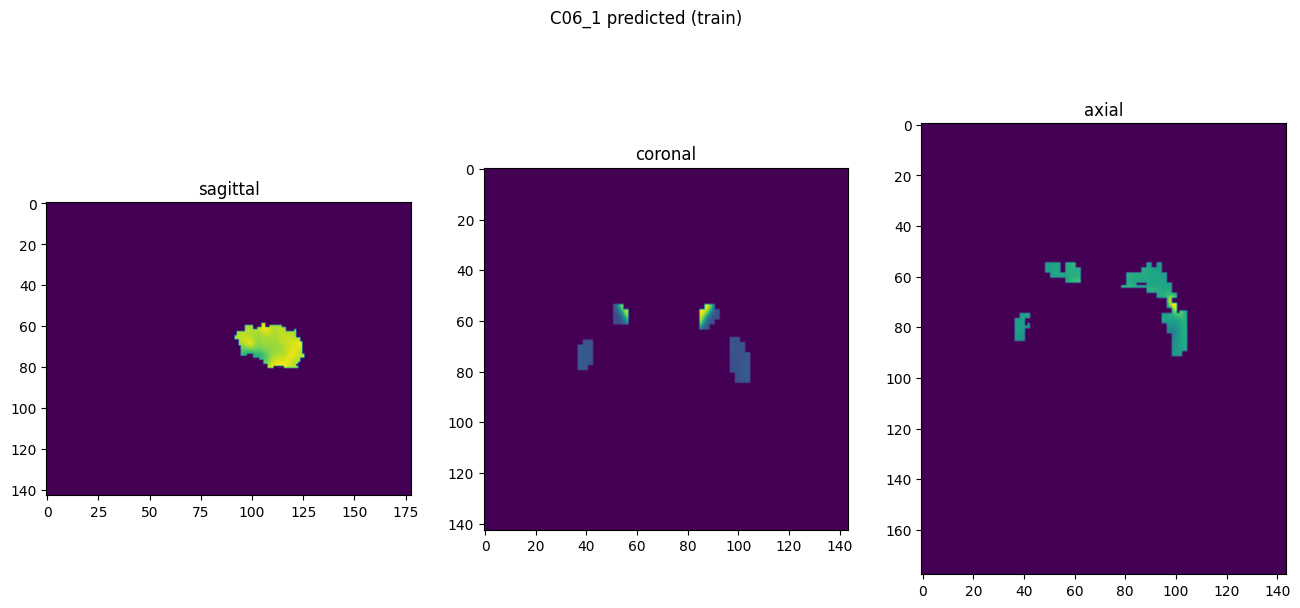

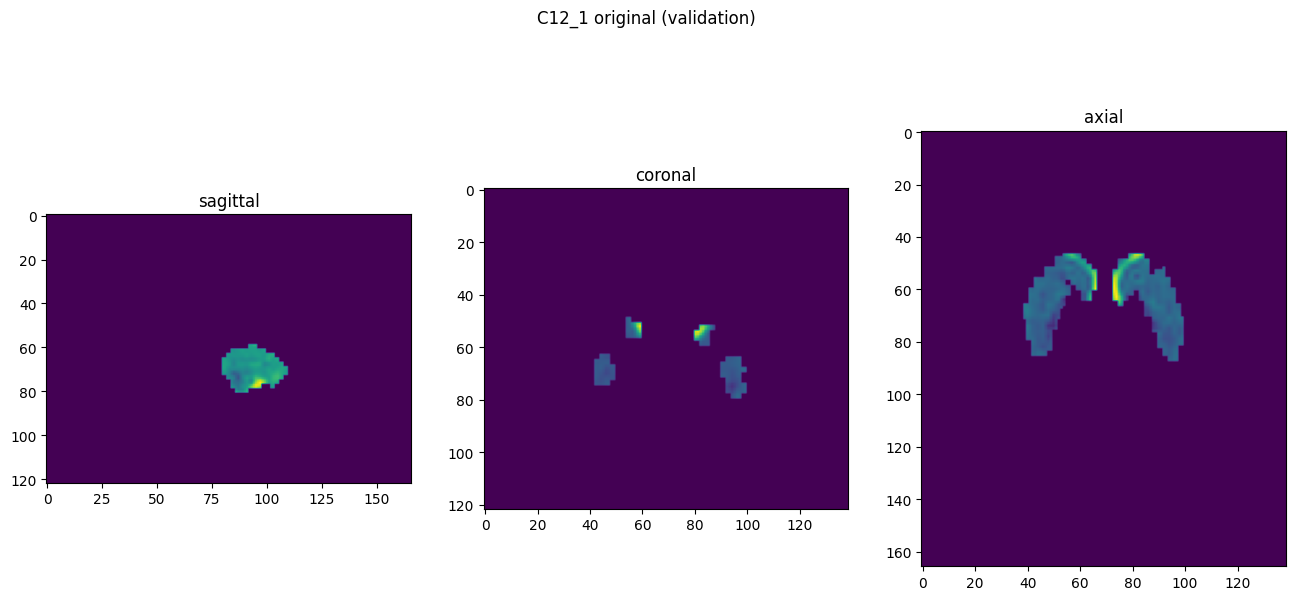

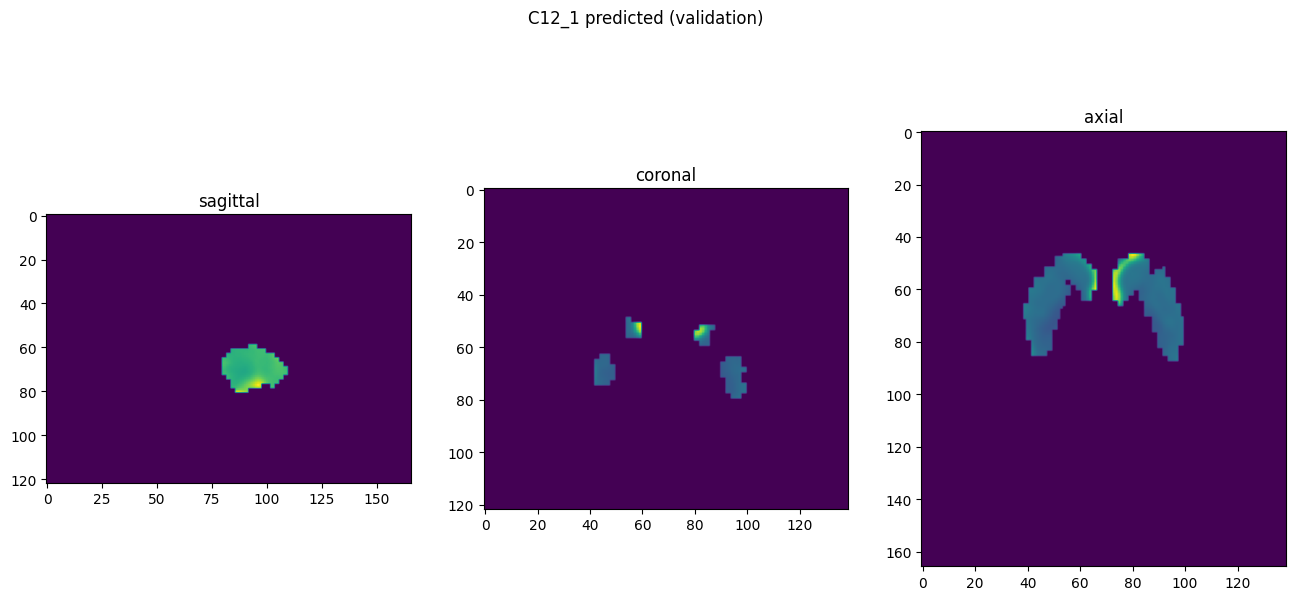

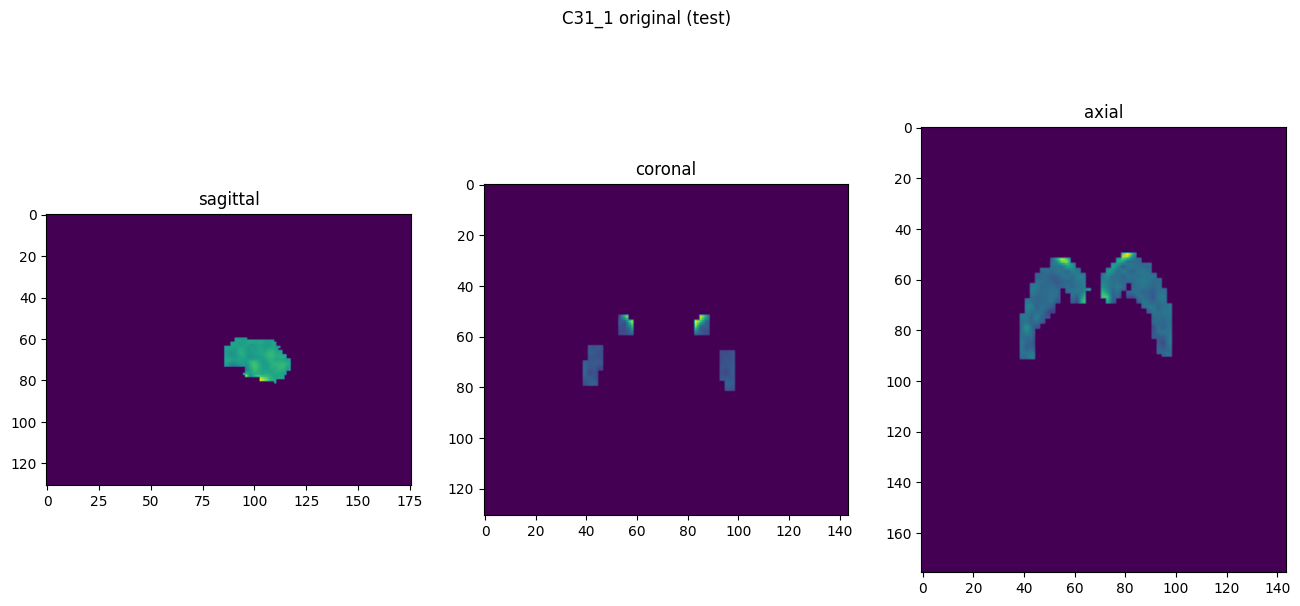

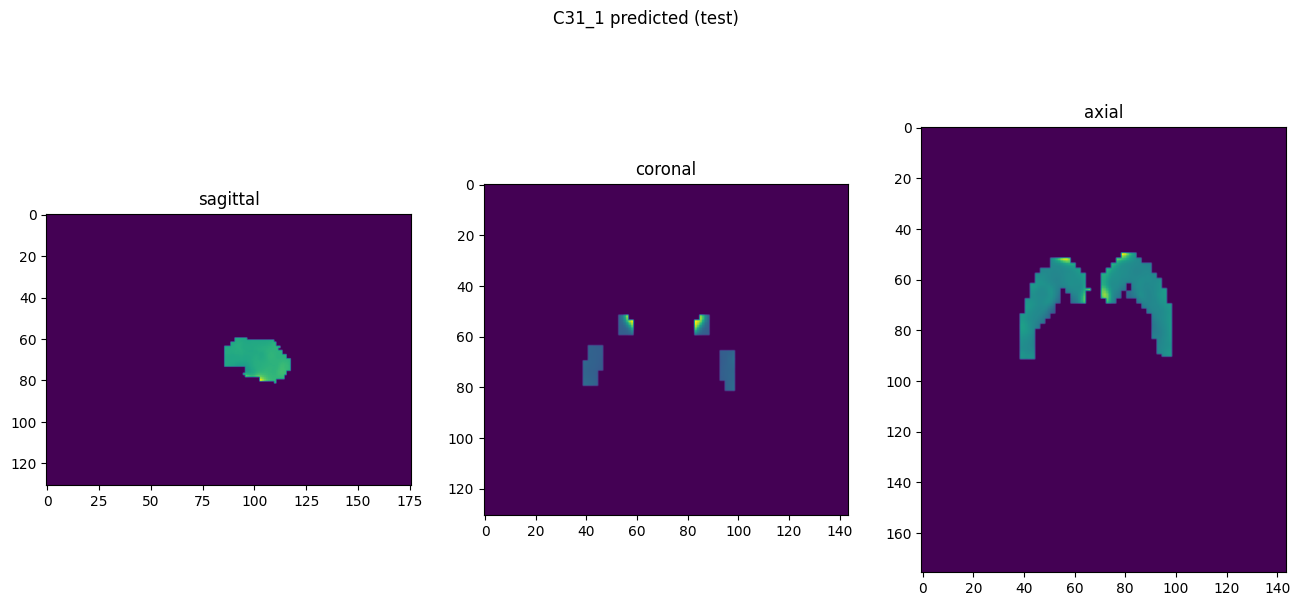

In [10]:
showResults(model, gen, threshold=None, background=False)